<a href="https://colab.research.google.com/github/lizmosquera/InteligenciaComputacional/blob/master/Resultado1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from math import sqrt

from numpy import concatenate

import numpy as np
import os
import pandas as pd

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import torch
#from torch.autograd import Variable
import torch


In [0]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

%matplotlib inline
import matplotlib.pyplot as plt

def plot_series(time,series,format="-",start=0,end=None):
  plt.plot(time[start:end],series[start:end],format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean
print (tf.keras.__version__)
print (pd.__version__)

2.3.0-tf
1.0.3


In [5]:
df = pd.read_csv('Datos_TRM.csv', header=0, index_col=1)
#dataset.index = dataset['Date Time']
df.index.name = 'date'
df=df.drop(['Index','FF_EfcRate'], axis=1)
df.tail(5)

,TRM,TRM_logn,IBR,YTES1Y_COP,YTES5Y_COP,YTES10Y_COP,YTES1Y_UVR,YTES5Y_UVR,YTES10Y_UVR,FF_UB,WTI_USD,GOLD_USD,VAR_TRM,VAR_LNTRM,MM_5,MM_20
date,,,,,,,,,,,,,,,,
24/04/2020,4020.94,8.299271,0.03706,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.25,16.94,1735.6,-17.01,-0.004221,4008.944,3990.5985
27/04/2020,4039.87,8.303968,0.03675,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.25,12.78,1723.8,18.93,0.004697,4022.306,3988.2750
28/04/2020,4039.83,8.303958,0.03677,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.25,12.34,1722.2,-0.04,-0.000010,4036.720,3990.4750
29/04/2020,4046.04,8.305494,0.03712,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.25,15.06,1713.4,6.21,0.001536,4036.926,3990.6370
30/04/2020,3983.29,8.289863,0.03712,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.25,15.06,1713.4,-62.75,-0.015631,4025.994,3986.5610


El parámetro history_size es el tamaño de la ventana de información pasada. El target_size es qué tan lejos en el futuro necesita el modelo aprender a predecir. Target_size es la etiqueta que debe predecirse.

In [6]:
df.describe()

,TRM,TRM_logn,IBR,YTES1Y_COP,YTES5Y_COP,YTES10Y_COP,YTES1Y_UVR,YTES5Y_UVR,YTES10Y_UVR,FF_UB,WTI_USD,GOLD_USD,VAR_TRM,VAR_LNTRM,MM_5,MM_20
count,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000
mean,3048.219539,8.018003,0.052413,0.053287,0.063457,0.072009,0.015956,0.027207,0.033723,1.219727,52.163195,1292.769602,1.266305,0.000408,3045.650986,3036.331333
std,286.087760,0.092594,0.012612,0.009529,0.007822,0.007833,0.006387,0.004965,0.004495,0.798633,10.781998,134.213180,26.957999,0.008568,283.565014,274.227040
min,2360.580000,7.766663,0.035160,0.038254,0.050234,0.058742,0.004537,0.015435,0.021375,0.250000,-37.630000,1050.800000,-94.370000,-0.030407,2372.094000,2385.795000
25%,2902.192500,7.973222,0.042540,0.046093,0.058596,0.067309,0.011296,0.024805,0.032274,0.500000,46.437500,1208.050000,-13.947500,-0.004535,2901.454000,2909.559625
50%,3003.065000,8.007389,0.045170,0.048312,0.061477,0.070298,0.014619,0.027179,0.033740,1.250000,52.295000,1271.450000,0.395000,0.000132,3001.658000,3000.484250
75%,3194.892500,8.069309,0.062490,0.062428,0.067033,0.075008,0.020063,0.030237,0.035839,2.000000,59.022500,1334.400000,15.520000,0.005170,3190.723500,3200.109625
max,4153.910000,8.331805,0.077880,0.073609,0.088001,0.096859,0.039636,0.043588,0.045797,2.500000,76.410000,1768.900000,219.020000,0.059307,4110.698000,4031.675000


In [7]:
values=df.values
values=values.astype('float32')
values

array([[ 2.3973501e+03,  7.7821193e+00,  4.5359999e-02, ...,
         1.4677443e-02,  2.3827319e+03,  2.3976875e+03],
       [ 2.4411001e+03,  7.8002038e+00,  4.5249999e-02, ...,
         1.8084796e-02,  2.3936521e+03,  2.4001194e+03],
       [ 2.4072900e+03,  7.7862568e+00,  4.5230001e-02, ...,
        -1.3947124e-02,  2.3978540e+03,  2.4013154e+03],
       ...,
       [ 4.0398301e+03,  8.3039579e+00,  3.6770001e-02, ...,
        -9.8999999e-06,  4.0367200e+03,  3.9904751e+03],
       [ 4.0460400e+03,  8.3054943e+00,  3.7120000e-02, ...,
         1.5360130e-03,  4.0369260e+03,  3.9906370e+03],
       [ 3.9832900e+03,  8.2898636e+00,  3.7120000e-02, ...,
        -1.5630513e-02,  4.0259939e+03,  3.9865610e+03]], dtype=float32)

In [0]:
def ts(new_data,look_back=1,pred_col=1):
  t=new_data.copy()
  t["id"]=range(1,len(t)+1)
  t=t.iloc[:-look_back,:]
  t.set_index('id',inplace=True)
  pred_value=new_data.copy()
  pred_value=pred_value.iloc[look_back:,pred_col]
  pred_value.columns=['Pred']
  pred_value=pd.DataFrame(pred_value)

  pred_value["id"]=range(1,len(pred_value)+1)
  pred_value.set_index('id',inplace=True)
  final_df=pd.concat([t,pred_value],axis=1)

  return final_df

In [10]:
#scaler=MinMaxScaler(feature_range=(0,1))
scaler=StandardScaler()
scaled=scaler.fit_transform(values)
scaled=pd.DataFrame(scaled)
scaled.head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-2.275958,-2.548497,-0.559462,-0.849469,-0.930997,-0.334971,-1.716120,-1.202947,-0.375006,-1.214708,-0.364007,-0.106362,1.249234,1.665986,-2.338717,-2.329798
1,-2.122973,-2.353111,-0.568187,-0.860331,-1.074137,-0.420529,-1.788469,-1.323646,-0.402502,-1.214708,-0.240606,-0.123506,1.576538,2.063806,-2.300191,-2.320926
2,-2.241200,-2.503795,-0.569773,-0.798462,-1.038674,-0.440429,-1.754724,-1.243536,-0.334969,-1.214708,0.082281,-0.246493,-1.301655,-1.676023,-2.285367,-2.316563
3,-2.355091,-2.650965,-0.563427,-0.734665,-0.945031,-0.372073,-1.760960,-1.234419,-0.292480,-1.214708,-0.344523,-0.215932,-1.255640,-1.638075,-2.289876,-2.323512


In [11]:
arr_df=ts(scaled,1,0)
arr_df.fillna(0,inplace=True)

arr_df.columns=['v1(t-1)','v2(t-1)','v3(t-1)','v4(t-1)','v5(t-1)','v6(t-1)'
,'v7(t-1)','v8(t-1)','v9(t-1)','v10(t-1)','v11(t-1)','v12(t-1)','v13(t-1)'
,'v14(t-1)','v15(t-1)','v16(t-1)','v1(t)'] #,'v17(t-1)'
print(arr_df.head())

     v1(t-1)   v2(t-1)   v3(t-1)  ...  v15(t-1)  v16(t-1)     v1(t)
id                                ...                              
1  -2.275958 -2.548497 -0.559462  ... -2.338717 -2.329798 -2.122973
2  -2.122973 -2.353111 -0.568187  ... -2.300191 -2.320926 -2.241200
3  -2.241200 -2.503795 -0.569773  ... -2.285367 -2.316563 -2.355091
4  -2.355091 -2.650965 -0.563427  ... -2.289876 -2.323512 -2.329950
5  -2.329950 -2.618303 -0.560255  ... -2.276124 -2.336317 -2.320788

[5 rows x 17 columns]


In [12]:
#Split & Convert Data to Right Shape
values=arr_df.values
train_sample=int(len(df)*0.936)
train=values[:train_sample,:]
test=values[train_sample:,:]

#split into input and outputs
xtrain, ytrain=train[:,:-1],train[:,-1]
xtest,ytest=test[:,:-1],test[:,-1]

print(xtrain.shape,ytrain.shape,xtest.shape,ytest.shape)

(1198, 16) (1198,) (81, 16) (81,)


In [13]:
#Reshaping the data sert to 3D with sample size, lookback time steps, and the input features.
xtrain=xtrain.reshape((xtrain.shape[0],1,xtrain.shape[1]))
xtest=xtest.reshape((xtest.shape[0],1,xtest.shape[1]))

print(xtrain.shape,ytrain.shape,xtest.shape,ytest.shape)

(1198, 1, 16) (1198,) (81, 1, 16) (81,)


In [14]:
model_lstm=tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(75,return_sequences=True,
                                    input_shape=(train.shape[1],xtrain.shape[2])))
model_lstm.add(tf.keras.layers.LSTM(units=30,return_sequences=True))
model_lstm.add(tf.keras.layers.LSTM(units=30))
model_lstm.add(tf.keras.layers.Dense(units=1))

model_lstm.compile(loss='mae',optimizer='adam')
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 17, 75)            27600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 17, 30)            12720     
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 47,671
Trainable params: 47,671
Non-trainable params: 0
_________________________________________________________________


In [15]:
#fit network
history_lstm=model_lstm.fit(xtrain,ytrain,epochs=50,batch_size=64,
                            validation_data=(xtest,ytest),shuffle=False)

Epoch 1/50
19/19 [==============================] - 1s 59ms/step - loss: 0.6390 - val_loss: 2.1139
Epoch 2/50
19/19 [==============================] - 0s 6ms/step - loss: 0.6212 - val_loss: 2.0835
Epoch 3/50
19/19 [==============================] - 0s 6ms/step - loss: 0.5771 - val_loss: 1.9730
Epoch 4/50
19/19 [==============================] - 0s 6ms/step - loss: 0.4444 - val_loss: 1.7460
Epoch 5/50
19/19 [==============================] - 0s 8ms/step - loss: 0.3158 - val_loss: 1.5977
Epoch 6/50
19/19 [==============================] - 0s 7ms/step - loss: 0.2050 - val_loss: 1.4492
Epoch 7/50
19/19 [==============================] - 0s 7ms/step - loss: 0.1753 - val_loss: 1.3438
Epoch 8/50
19/19 [==============================] - 0s 7ms/step - loss: 0.1584 - val_loss: 1.2563
Epoch 9/50
19/19 [==============================] - 0s 7ms/step - loss: 0.1480 - val_loss: 1.1892
Epoch 10/50
19/19 [==============================] - 0s 6ms/step - loss: 0.1498 - val_loss: 1.1155
Epoch 11/50
19/19 

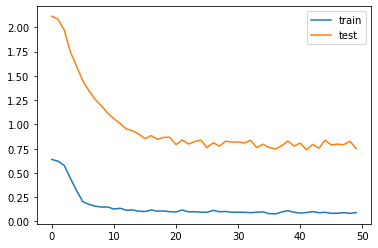

In [16]:
#plotting the training progression
plt.plot(history_lstm.history['loss'],label='train')
plt.plot(history_lstm.history['val_loss'],label='test')
plt.legend()
plt.show()

In [17]:
#make prediction
yhat=model_lstm.predict(xtest)
xtest=xtest.reshape((xtest.shape[0],xtest.shape[2]))

#invert scaling for forecast
inv_yhat=concatenate((yhat,xtest[:,1:]),axis=1)
inv_yhat=scaler.inverse_transform(inv_yhat)
inv_yhat=inv_yhat[:,0]

#invert scaling for actual
ytest=ytest.reshape((len(ytest),1))
inv_y=concatenate((ytest,xtest[:,1:]),axis=1)
inv_y=scaler.inverse_transform(inv_y)
inv_y=inv_y[:,0]


In [18]:
print("Mean absolute error (MAE):       %f"% mean_absolute_error(inv_y,inv_yhat))
print("Mean squared error (MSE):        %f"% mean_squared_error(inv_y,inv_yhat))
print("Root Mean squared error (RMSE):  %f"% sqrt(mean_squared_error(inv_y,inv_yhat)))
print("R square (R^2):                  %f"% r2_score(inv_y,inv_yhat))

Mean absolute error (MAE):       214.718964
Mean squared error (MSE):        98422.781250
Root Mean squared error (RMSE):  313.724053
R square (R^2):                  0.014420


<function matplotlib.pyplot.show>

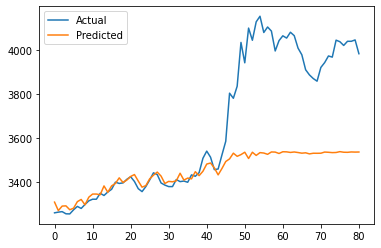

In [19]:
 plt.plot(inv_y,label='Actual')
 plt.plot(inv_yhat,label='Predicted')
 plt.legend()
 plt.show

In [49]:
#Split & Convert Data to Right Shape
values=arr_df.values
train_sample=int(len(df)*0.936)
train=values[:train_sample,:]
test=values[train_sample:,:]

#split into input and outputs
xtrain, ytrain=train[:,:-1],train[:,-1]
xtest,ytest=test[:,:-1],test[:,-1]

print(xtrain.shape,ytrain.shape,xtest.shape,ytest.shape)

#Reshaping the data sert to 3D with sample size, lookback time steps, and the input features.
xtrain=xtrain.reshape((xtrain.shape[0],1,xtrain.shape[1]))
xtest=xtest.reshape((xtest.shape[0],1,xtest.shape[1]))

print(xtrain.shape,ytrain.shape,xtest.shape,ytest.shape)

(1198, 16) (1198,) (81, 16) (81,)
(1198, 1, 16) (1198,) (81, 1, 16) (81,)


In [50]:
#https://towardsdatascience.com/recurrent-neural-network-to-predict-multivariate-commodity-prices-8a8202afd853
model_lstm=tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(50,return_sequences=True,
                                    input_shape=(train.shape[1],xtrain.shape[2])))
model_lstm.add(tf.keras.layers.LSTM(units=60,return_sequences=True))
model_lstm.add(tf.keras.layers.LSTM(units=60))
model_lstm.add(tf.keras.layers.Dense(30,activation="relu"))
model_lstm.add(tf.keras.layers.Dense(units=1))

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model_lstm.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
#model_lstm.compile(loss='mae',optimizer='adam')
model_lstm.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 17, 50)            13400     
_________________________________________________________________
lstm_22 (LSTM)               (None, 17, 60)            26640     
_________________________________________________________________
lstm_23 (LSTM)               (None, 60)                29040     
_________________________________________________________________
dense_11 (Dense)             (None, 30)                1830      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 31        
Total params: 70,941
Trainable params: 70,941
Non-trainable params: 0
_________________________________________________________________


In [51]:
#fit network
history_lstm=model_lstm.fit(xtrain,ytrain,epochs=50,batch_size=64,
                            validation_data=(xtest,ytest),shuffle=False)

Epoch 1/50
19/19 [==============================] - 1s 52ms/step - loss: 0.2984 - mae: 0.6395 - val_loss: 1.6074 - val_mae: 2.1045
Epoch 2/50
19/19 [==============================] - 0s 6ms/step - loss: 0.2983 - mae: 0.6394 - val_loss: 1.6076 - val_mae: 2.1047
Epoch 3/50
19/19 [==============================] - 0s 6ms/step - loss: 0.2983 - mae: 0.6393 - val_loss: 1.6077 - val_mae: 2.1048
Epoch 4/50
19/19 [==============================] - 0s 6ms/step - loss: 0.2982 - mae: 0.6392 - val_loss: 1.6079 - val_mae: 2.1050
Epoch 5/50
19/19 [==============================] - 0s 6ms/step - loss: 0.2982 - mae: 0.6391 - val_loss: 1.6081 - val_mae: 2.1052
Epoch 6/50
19/19 [==============================] - 0s 7ms/step - loss: 0.2981 - mae: 0.6390 - val_loss: 1.6082 - val_mae: 2.1054
Epoch 7/50
19/19 [==============================] - 0s 7ms/step - loss: 0.2980 - mae: 0.6389 - val_loss: 1.6084 - val_mae: 2.1055
Epoch 8/50
19/19 [==============================] - 0s 7ms/step - loss: 0.2980 - mae: 0.6

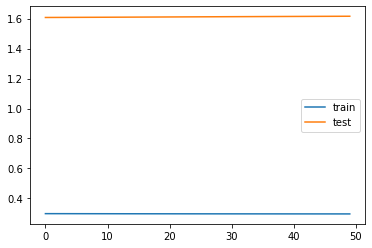

In [52]:
#plotting the training progression
plt.plot(history_lstm.history['loss'],label='train')
plt.plot(history_lstm.history['val_loss'],label='test')
plt.legend()
plt.show()

In [53]:
print("Mean absolute error (MAE):       %f"% mean_absolute_error(inv_y,inv_yhat))
print("Mean squared error (MSE):        %f"% mean_squared_error(inv_y,inv_yhat))
print("Root Mean squared error (RMSE):  %f"% sqrt(mean_squared_error(inv_y,inv_yhat)))
print("R square (R^2):                  %f"% r2_score(inv_y,inv_yhat))

Mean absolute error (MAE):       220.323792
Mean squared error (MSE):        103396.140625
Root Mean squared error (RMSE):  321.552703
R square (R^2):                  -0.035382


In [0]:
#make prediction
yhat=model_lstm.predict(xtest)
xtest=xtest.reshape((xtest.shape[0],xtest.shape[2]))

#invert scaling for forecast
inv_yhat=concatenate((yhat,xtest[:,1:]),axis=1)
inv_yhat=scaler.inverse_transform(inv_yhat)
inv_yhat=inv_yhat[:,0]

#invert scaling for actual
ytest=ytest.reshape((len(ytest),1))
inv_y=concatenate((ytest,xtest[:,1:]),axis=1)
inv_y=scaler.inverse_transform(inv_y)
inv_y=inv_y[:,0]

<function matplotlib.pyplot.show>

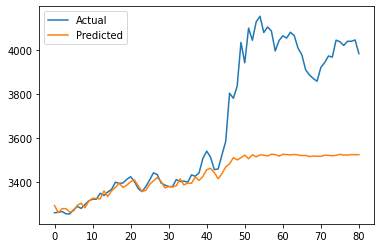

In [55]:
plt.plot(inv_y,label='Actual')
plt.plot(inv_yhat,label='Predicted')
plt.legend()
plt.show